# Multimodal HepB vaccine response predictions

In [1]:
import numpy as np
import pandas as pd
import warnings
import seaborn as sns
from natsort import index_natsorted

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from mvlearn.embed import MCCA
from mvlearn.decomposition import GroupPCA

from multiview_hepB.plotting import *
from multiview_hepB.multiview_training import *
from multiview_hepB.preprocessing import *

HEP_DIR = "./data/"

colors = ["goldenrod", "#2ca02c", "darkblue"]

warnings.filterwarnings("ignore")

#import plotly.io as pio
#pio.renderers.default = "vscode"

## Data Loading

In [2]:
# Metadata import
meta_hep = pd.read_csv(HEP_DIR + 'meta.txt', sep='\t')
meta = pd.read_excel(HEP_DIR + 'HBVgegevens_anon.xlsx', skiprows=[0], sheet_name='Opvolging')

meta_hep['Vaccinee'] = ['H' + str(x) for x in meta_hep['Vaccinee']]
meta.rename(columns={'Subjectnr':'Vaccinee', 'Temperatuur':'Temperature'}, inplace=True)

meta = meta.iloc[::7][['Bloeddruk', 'Temperature', 'Vaccinee']]
meta.reset_index(drop = True, inplace = True)
meta = meta.iloc[:-1:]
meta[['Max_BP','Min_BP']] = meta['Bloeddruk'].str.split('/',expand=True)
meta.drop(columns=['Bloeddruk'], inplace=True)

# TCRseq data import
TCRseq_pred = pd.read_csv(HEP_DIR + 'TCRseq_pred_cv.txt', sep='\t')

# Label data import
""" Any antibody titer above 10 IU can be considered a responder at a given time."""
responder_classes = pd.read_csv(HEP_DIR + 'responder_classes.txt', sep='\t')

# Full (unnormalized) read count file for the transcriptomics data
readcounts = pd.read_csv(HEP_DIR + 'readcounts.txt', sep='\t')

# Cell counts readings
cellcounts = pd.read_csv(HEP_DIR + 'cellcounts.txt', sep='\t')

# Gene mapping table
gene_mapping = pd.read_csv(HEP_DIR + 'genes.txt', sep='\t',
                            names=["Gene.ID", "0", "1", "Gene.Name", "Gene.Description", "2","3","4","5","6"])[['Gene.ID','Gene.Name']]

# Mapping table for Gene to Module Function 
module_list = pd.read_csv(HEP_DIR + 'module_list.csv')

In [3]:
""" Summary statistics for the TCRseq data prior to vaccination.

For each Vaccinee: 

    - B0: number of  TCRs sequenced in the CD4+ memory 
    - PPnrB0: frequency of bystander TCRs in this compartment 
    - PSB0: frequency of vaccine-specific TCRs in this compartment  
    - HepBTCRs: Ratio of the previous two that has been shown to be a good predictor for response

The last column is the output of a TCR-epitope classifier (leave-one-out). """
TCRseq_pred.rename(columns={'Patient':'Vaccinee'}, inplace=True)
TCRseq_pred.sort_values(by='Vaccinee', inplace=True, key=lambda x: np.argsort(index_natsorted(TCRseq_pred["Vaccinee"])))
TCRseq_pred.head()

Vaccinee     B0    PPnrB0      PSB0  HepBTCRs
21       H2  87551  0.056180  0.045332  0.806917
4        H3  39228  0.022308  0.017817  0.798710
29       H4  36807  0.023274  0.019735  0.847935
25       H6  29330  0.017190  0.013999  0.814398
11       H7  39900  0.020833  0.021270  1.020942

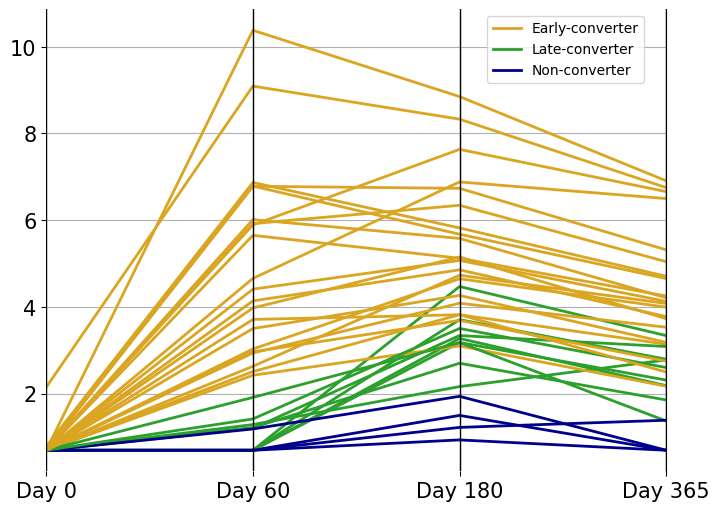

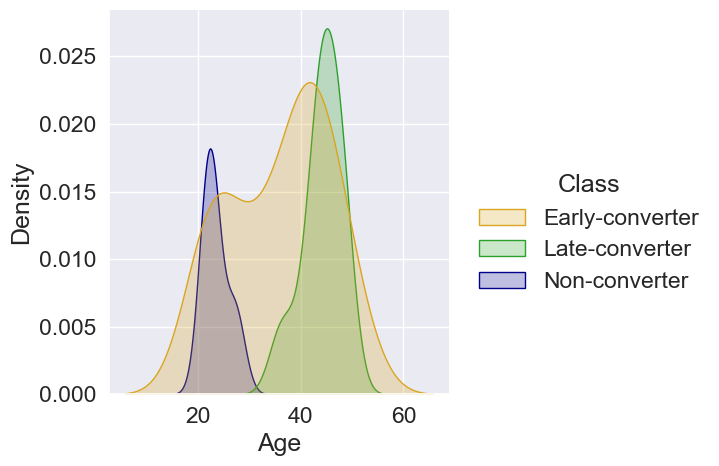

In [4]:
pivoted = ab_titers_inspection(meta_hep, responder_classes, colors)
# remove outliers for visualisation purposes
plot_projection('ab_pca', pivoted[~pivoted['Vaccinee'].isin(['H32', 'H19'])], colors)
# remove 'duplicate rows' to extract the patient's age
age_dist_plot(pivoted.merge(meta_hep[::4].reset_index(drop=True), left_on='Vaccinee', right_on='Vaccinee')[['Class','Vaccinee', 'Age']], colors)


In [5]:
### Drop Non-converter individuals from all datasets
responder_classes = responder_classes[responder_classes['Class'] != 'Non-converter'].reset_index(drop=True)
### Copy class labels to also have binary equivalent
classes = responder_classes['Class'].copy()
classes.replace({"Early-converter": 1, "Late-converter": 0}, inplace = True)
### Color bar mapping
lut = dict(zip(responder_classes['Class'].unique(), sns.hls_palette(len(set(responder_classes['Class'].unique())), l=0.5, s=0.5, h=.75)))
row_colors = responder_classes['Class'].map(lut)

cellcounts = cellcounts[cellcounts['Vaccinee'].isin(responder_classes['Vaccinee'])].reset_index(drop=True)
meta_hep = meta_hep[meta_hep['Vaccinee'].isin(responder_classes['Vaccinee'])].reset_index(drop=True)
meta = meta[meta['Vaccinee'].isin(responder_classes['Vaccinee'])].reset_index(drop=True)
TCRseq_pred = TCRseq_pred[TCRseq_pred['Vaccinee'].isin(responder_classes['Vaccinee'])].reset_index(drop=True)

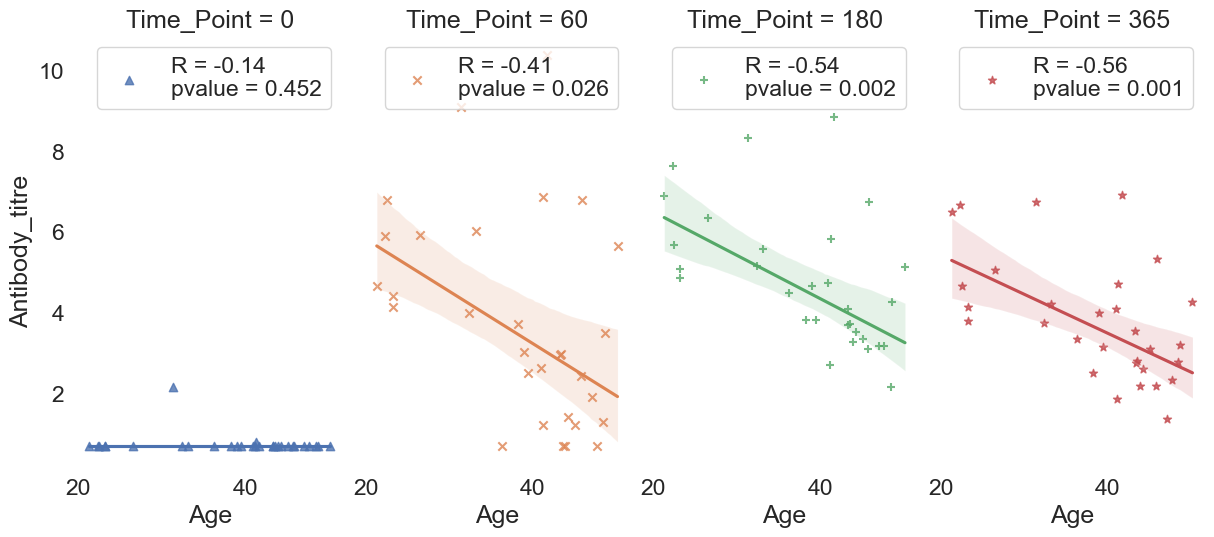

In [6]:
ab_titers_timedep(meta_hep, colors)

In [7]:
# merge the two metadata dataframes
meta_hep = pd.merge(meta_hep[['Vaccinee', 'Gender', 'Age']][::4], meta, on='Vaccinee')
meta_hep.iloc[:,-4:] = meta_hep.iloc[:,-4:].apply(pd.to_numeric)

In [8]:
metadata_dist_plot(meta_hep, responder_classes, colors)
cellcounts_dist_plot(cellcounts, responder_classes, colors)
TCRseq_dist_plot(TCRseq_pred, responder_classes, colors)

[0.2476424660791231, 0.8385358702212659, 0.785768160361353, 0.9638950057771021, 0.6670690742839049, 0.2049411978989919, 0.08903337955865856, 0.13531752008080955]


[0.1893743535622313, 0.38906861097536205, 0.11320057404119496, 0.0032645989059973722]


In [9]:
readcounts = readcounts_preprocessing(readcounts, responder_classes, gene_mapping)

Readcounts size: (13012, 31)


In [10]:
res, normalized_count_hep = deseq2(readcounts, responder_classes)

INFO:DESeq2:Using contrast: ['Class', 'Late-converter', 'Early-converter']
INFO:DESeq2:Normalizing counts


In [11]:
res.sort_values(by=['padj'], ascending=True)[res['padj'] <= 0.05]

baseMean  log2FoldChange     lfcSE      stat        pvalue  \
HLA-DRB5  133.947824       -4.958286  0.882093 -5.621044  1.898073e-08   

              padj Gene.Name  
HLA-DRB5  0.000247  HLA-DRB5

In [12]:
### Gene aggregation into BTMs
RNA_seqs = aggregate_modules('mean', normalized_count_hep, module_list).apply(pd.to_numeric)

In [13]:
onehot = pd.get_dummies(meta_hep.Gender, prefix='Gender')
meta_hep['Gender_F'] = onehot['Gender_F']
meta_hep.drop(columns = {'Gender'},inplace = True)
merged = meta_hep.merge(TCRseq_pred,on='Vaccinee').merge(cellcounts,on='Vaccinee')
merged.head()

Vaccinee   Age  Temperature  Max_BP  Min_BP  Gender_F     B0    PPnrB0  \
0       H2  43.6        36.59     103      67         1  87551  0.056180   
1       H3  48.5        37.19     123      61         1  39228  0.022308   
2       H4  47.1        36.40     144      86         0  36807  0.023274   
3       H6  44.3        36.70     112      69         1  29330  0.017190   
4       H7  38.3        36.47     130      69         0  39900  0.020833   

       PSB0  HepBTCRs  WBC0  RBC0  HGB0  HCT0  PLT0  LYM0  MON0  GRA0  
0  0.045332  0.806917   5.4  4.86  14.1  42.7   261  38.7   3.9  57.4  
1  0.017817  0.798710   7.0  4.16   8.1  26.2   403  25.5   4.3  70.2  
2  0.019735  0.847935   9.3  4.74  15.1  44.6   227  35.7   4.2  60.1  
3  0.013999  0.814398   5.8  4.24  12.3  36.7   235  35.1   4.1  60.8  
4  0.021270  1.020942   4.1  4.98  14.8  45.1   164  42.3   5.1  52.6

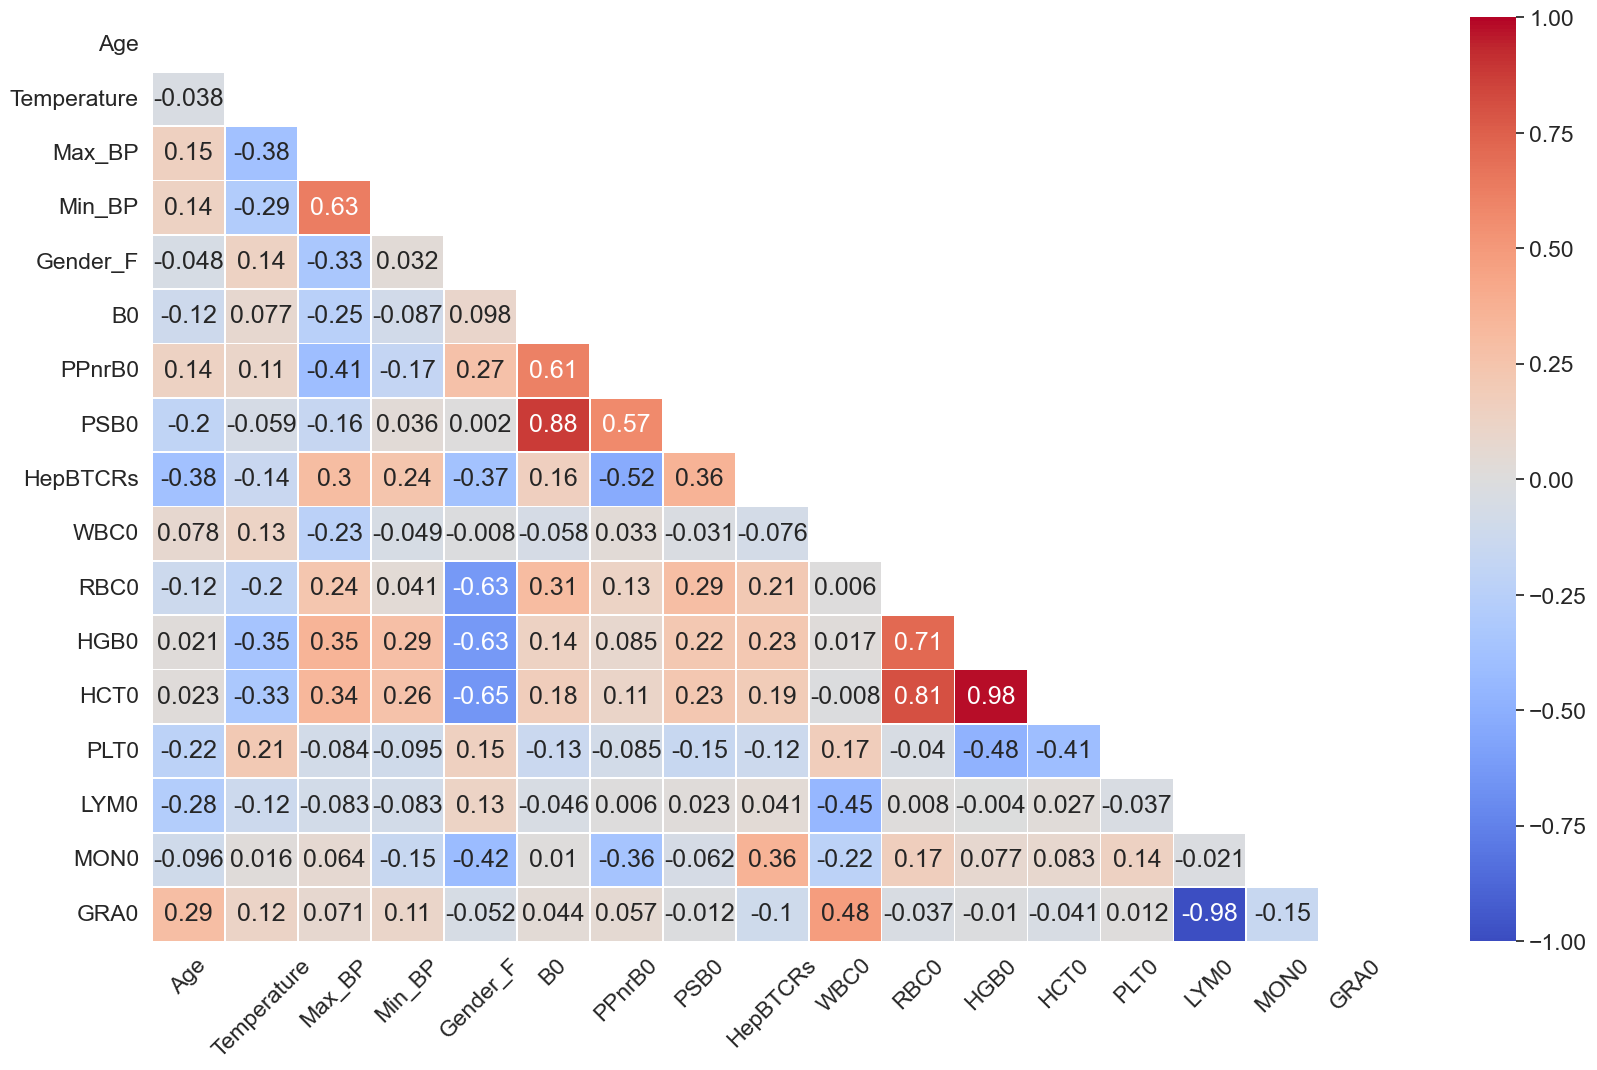

In [14]:
""" Collinearity. """
corr = merged.corr()
mask = np.triu(corr)
plot_cor_matrix(corr,mask)

## Multi-view Learning

In [15]:
results = []

Xs = [
        cellcounts.drop(columns = 'Vaccinee'),
        TCRseq_pred.drop(columns = 'Vaccinee'),
        meta_hep.drop(columns = 'Vaccinee'),
        RNA_seqs
    ]
    
Xs = [x.apply(pd.to_numeric) for x in Xs] 

for random_state in range(42, 62):

    print(f'\nIteration N: {random_state-41}\n')
    
    fusion_methods = instantiate_fusions(random_state)
    classifiers = instantiate_models(random_state)
    
    for clf in classifiers:

        print(f'\nModel in use: {clf[1]}\n')

        for implement in fusion_methods:

            performance = mvlearn_training(Xs, classes, implement, clf[0], random_state)

            results.append({'Results': performance, 'Model': clf[1]})


Iteration N: 1


Model in use: LogisticRegression

Implementation: Concat
Balanced Accuracy: 0.508 
AUC: 0.582
Implementation: Voting
Balanced Accuracy: 0.603 
AUC: 0.619
Implementation: PCA_singleview
Balanced Accuracy: 0.349 
AUC: 0.280
Implementation: PCA_multiview
Balanced Accuracy: 0.659 
AUC: 0.582
Implementation: GroupPCA
Balanced Accuracy: 0.706 
AUC: 0.783
Implementation: MCCA
Balanced Accuracy: 0.675 
AUC: 0.709

Model in use: RandomForest

Implementation: Concat
Balanced Accuracy: 0.452 
AUC: 0.638
Implementation: Voting
Balanced Accuracy: 0.516 
AUC: 0.569
Implementation: PCA_singleview
Balanced Accuracy: 0.500 
AUC: 0.492
Implementation: PCA_multiview
Balanced Accuracy: 0.595 
AUC: 0.688
Implementation: GroupPCA
Balanced Accuracy: 0.683 
AUC: 0.804
Implementation: MCCA
Balanced Accuracy: 0.619 
AUC: 0.762

Iteration N: 2


Model in use: LogisticRegression

Implementation: Concat
Balanced Accuracy: 0.532 
AUC: 0.577
Implementation: Voting
Balanced Accuracy: 0.603 
AUC: 0.6

Balanced Accuracy: 0.500 
AUC: 0.608
Implementation: MCCA
Balanced Accuracy: 0.484 
AUC: 0.656

Iteration N: 11


Model in use: LogisticRegression

Implementation: Concat
Balanced Accuracy: 0.508 
AUC: 0.587
Implementation: Voting
Balanced Accuracy: 0.627 
AUC: 0.651
Implementation: PCA_singleview
Balanced Accuracy: 0.571 
AUC: 0.550
Implementation: PCA_multiview
Balanced Accuracy: 0.611 
AUC: 0.624
Implementation: GroupPCA
Balanced Accuracy: 0.762 
AUC: 0.788
Implementation: MCCA
Balanced Accuracy: 0.643 
AUC: 0.751

Model in use: RandomForest

Implementation: Concat
Balanced Accuracy: 0.651 
AUC: 0.735
Implementation: Voting
Balanced Accuracy: 0.595 
AUC: 0.667
Implementation: PCA_singleview
Balanced Accuracy: 0.476 
AUC: 0.524
Implementation: PCA_multiview
Balanced Accuracy: 0.595 
AUC: 0.659
Implementation: GroupPCA
Balanced Accuracy: 0.659 
AUC: 0.754
Implementation: MCCA
Balanced Accuracy: 0.810 
AUC: 0.902

Iteration N: 12


Model in use: LogisticRegression

Implementation: Conc

Balanced Accuracy: 0.579 
AUC: 0.656
Implementation: GroupPCA
Balanced Accuracy: 0.532 
AUC: 0.709
Implementation: MCCA
Balanced Accuracy: 0.595 
AUC: 0.701


In [16]:
performance_eval(results)

Model: LogisticRegression

Method: Concat
AUC: 0.58+-0.006
Accuracy: 0.525+-0.011


Method: Voting
AUC: 0.645+-0.025
Accuracy: 0.634+-0.028


Method: PCA_singleview
AUC: 0.491+-0.105
Accuracy: 0.51+-0.073


Method: PCA_multiview
AUC: 0.541+-0.086
Accuracy: 0.602+-0.042


Method: GroupPCA
AUC: 0.751+-0.034
Accuracy: 0.663+-0.045


Method: MCCA
AUC: 0.732+-0.042
Accuracy: 0.631+-0.048


Model: RandomForest

Method: Concat
AUC: 0.657+-0.052
Accuracy: 0.509+-0.051


Method: Voting
AUC: 0.674+-0.04
Accuracy: 0.642+-0.061


Method: PCA_singleview
AUC: 0.444+-0.095
Accuracy: 0.477+-0.072


Method: PCA_multiview
AUC: 0.666+-0.041
Accuracy: 0.579+-0.054


Method: GroupPCA
AUC: 0.744+-0.054
Accuracy: 0.642+-0.075


Method: MCCA
AUC: 0.764+-0.083
Accuracy: 0.635+-0.079




## Factor analysis

In [17]:
Xs = [
        cellcounts.drop(columns = 'Vaccinee'),
        TCRseq_pred.drop(columns = 'Vaccinee'),
        meta_hep.drop(columns = 'Vaccinee'),
        RNA_seqs
    ]
Xs = [x.apply(pd.to_numeric) for x in Xs]
scaler = StandardScaler()

random_state = 42

### MCCA

In [18]:
Xs_values = [scaler.fit_transform(x) for x in Xs]

mcca = MCCA(n_components = 2, regs = [0.1,0.1,0.1,0.9],
          center = False, multiview_output=False)

Xs_mcca = mcca.fit_transform(Xs_values)

latent_contributions_plot(Xs, mcca, 'MCCA')

plot_projection('projection_mcca', Xs_mcca, colors, responder_classes)

circle_plot(Xs, Xs_mcca, list(responder_classes['Class']), 'MCCA')


### PCA

In [19]:
plot_projection('projection_pca', pd.concat([merged.merge(responder_classes, on='Vaccinee'), RNA_seqs], axis = 1), colors)

Xs_values = scaler.fit_transform(pd.concat(Xs, axis=1, ignore_index=False))
         
pca = PCA(n_components = 2)
Xs_PCA = pca.fit_transform(Xs_values) 

circle_plot(pd.concat(Xs, axis=1, ignore_index=False), Xs_PCA, list(responder_classes['Class']), 'PCA')

### GroupPCA

In [20]:
Xs_values = [scaler.fit_transform(x) for x in Xs]

groupPCA = GroupPCA(n_components = 2,
           multiview_output=False, prewhiten=True, whiten=True,
           random_state=random_state
            )

Xs_groupPCA = groupPCA.fit_transform(Xs_values)

latent_contributions_plot(Xs, groupPCA, 'GroupPCA')


## Analysing the outputs of distinct views

In [21]:
coefficients, results_single = single_view_training(Xs, responder_classes['Class'])

### Unimodal features importance

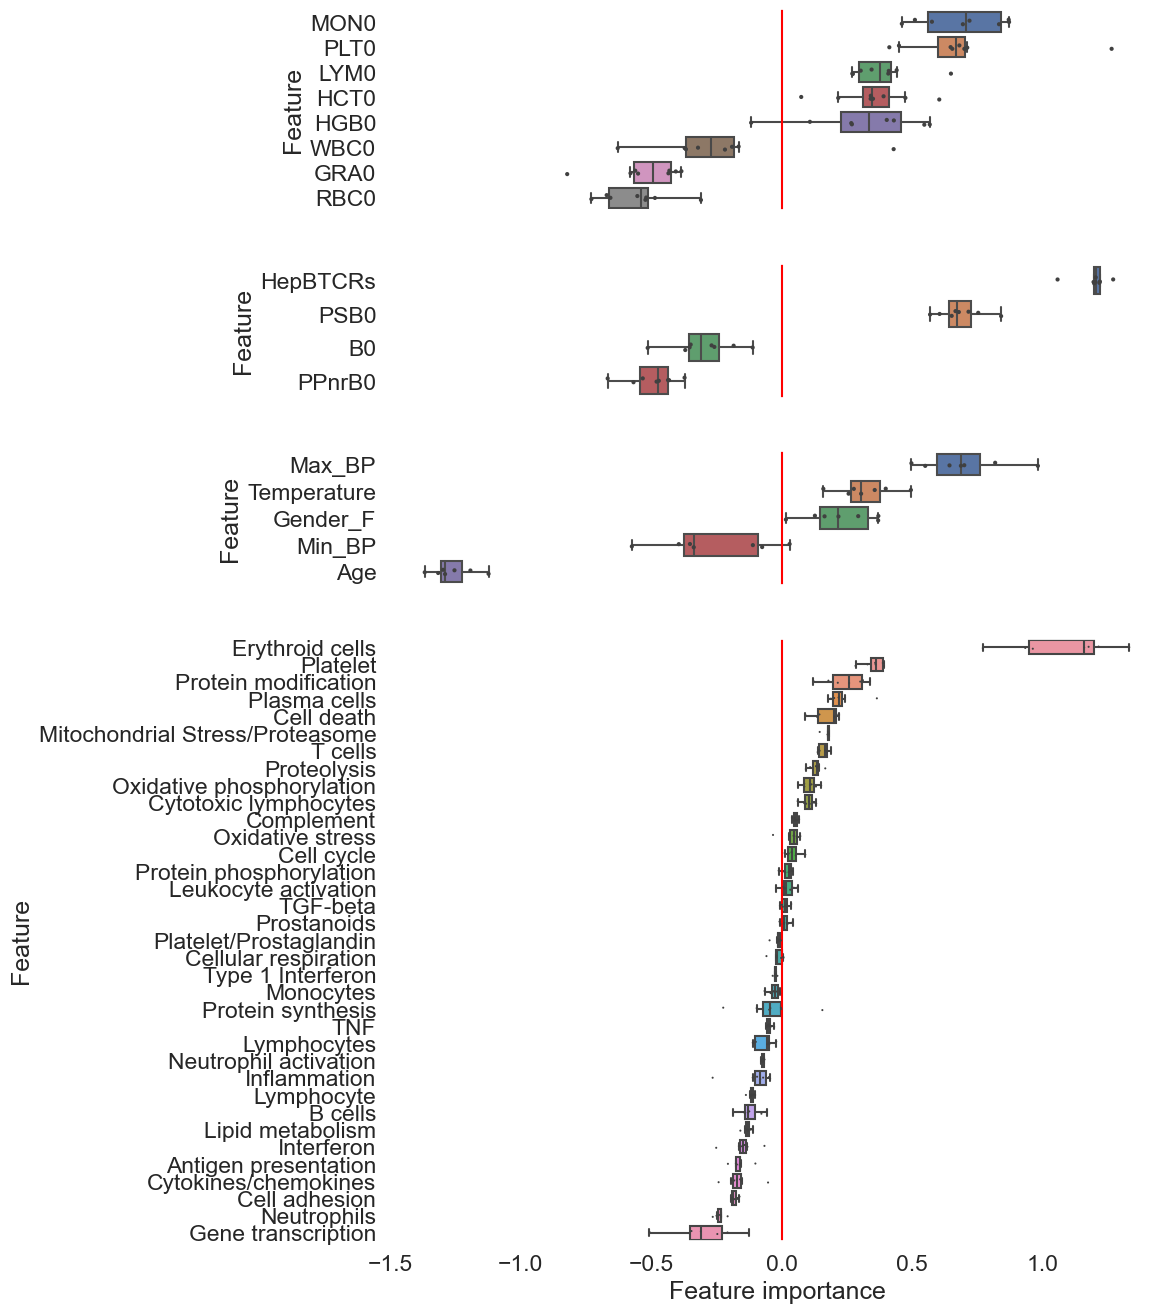

In [22]:
unimodal_featimp_plot(Xs, coefficients[:30])

### Unimodal performance

Considered view: Cellcounts_proba
AUC: 0.427+-0.037
Accuracy: 0.503+-0.041


Considered view: TCR_seq_proba
AUC: 0.731+-0.04
Accuracy: 0.706+-0.066


Considered view: metadata_proba
AUC: 0.588+-0.03
Accuracy: 0.588+-0.06


Considered view: RNA_seq_proba
AUC: 0.612+-0.009
Accuracy: 0.439+-0.019




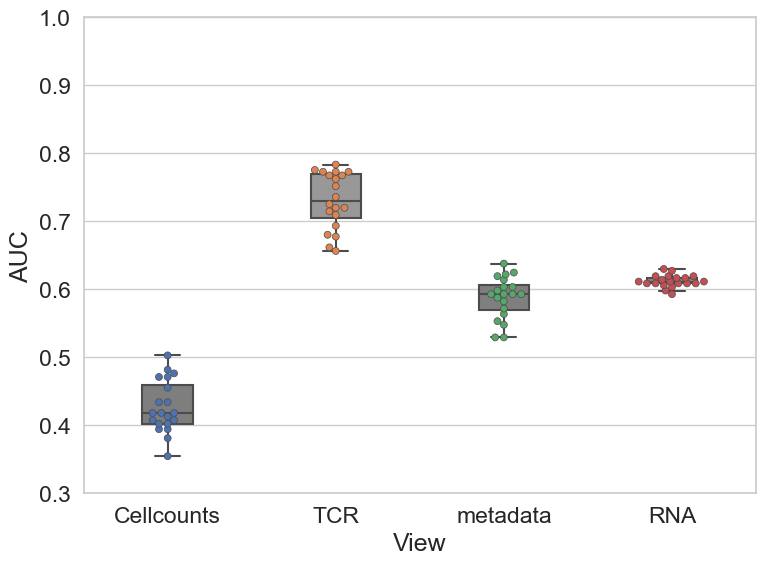

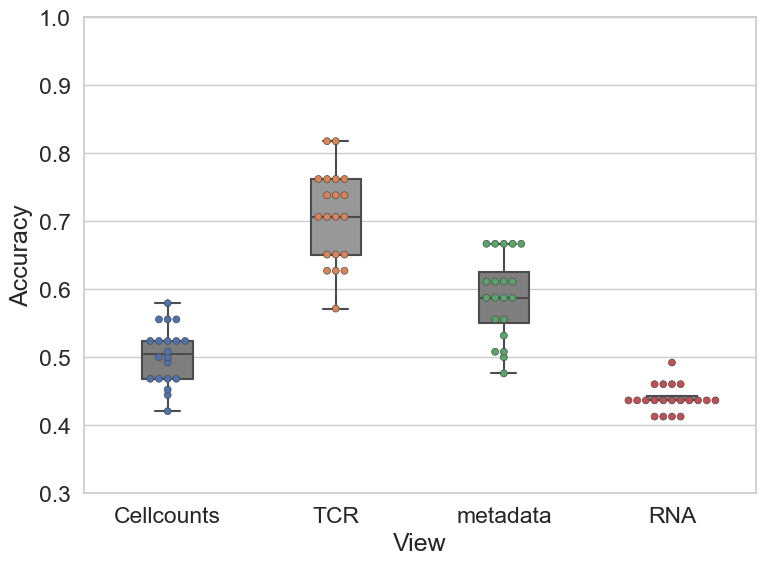

In [23]:
unimodal_performance_plot(results_single)

### Unimodal average predicted probabilities

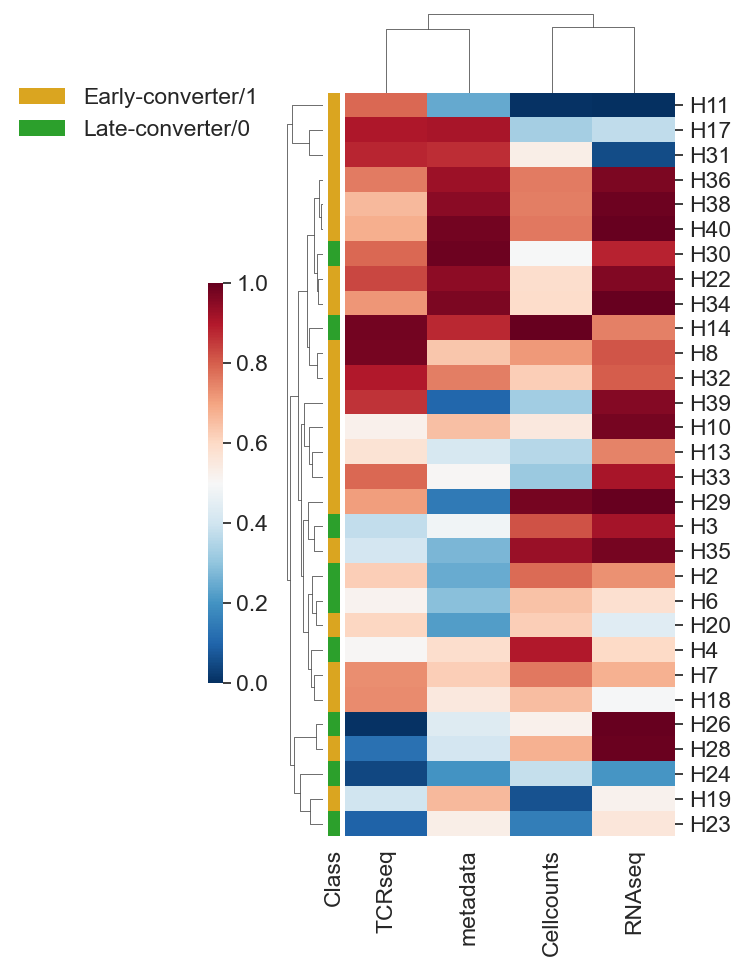

In [24]:
responder_classes['Class'].replace({"Early-converter": "Early-converter/1", "Late-converter": "Late-converter/0"}, inplace = True)
lut = dict(zip(responder_classes['Class'].unique(), [colors[1],colors[0]]))
row_colors = responder_classes['Class'].map(lut)

unimodal_proba = pd.DataFrame()
for view in ['Cellcounts_proba', 'TCR_seq_proba', 'metadata_proba', 'RNA_seq_proba']:
    aux = np.zeros(30)
    for arr in np.split(results_single, 20, axis=0):
        aux+=np.array(arr[view])
    aux/=20
    unimodal_proba[view] = aux

heatmap_predproba(unimodal_proba, responder_classes, lut, row_colors)
